# Figure 7 Linear Fits to $\Delta\!$ MLT

In this notebook we show how we perform the linear fits to $\Delta\!$ MLT for the mean IMF By and a sine fit for the Clock Angle.
This notebook produces Figure 7 in the related paper.

## Imports
First we import the functions we need

In [127]:
#%% Imports
import pandas as pd
import numpy as np
from scipy.stats import linregress, iqr
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.stats import t
from Subplot_alignment_tools import subplot_align
tinv = lambda p, df: abs(t.ppf(p/2, df))
import itertools

# Loading Dataset
Loading Onset file and created $\Delta\!$ MLT column

In [128]:
Onsets= pd.read_csv('./Mediated_Onsets.csv', parse_dates=['Date_NH'])
Onsets= Onsets[Onsets.flag==1][['Date_NH', 'Frey_MLT', 'Frey_MLAT', 'MLT_SH']]
Onsets.loc[Onsets.Frey_MLT<12, 'Frey_MLT']+=24
Onsets.loc[Onsets.MLT_SH<12, 'MLT_SH']+=24
Onsets['DMLT']= Onsets['MLT_SH']-Onsets['Frey_MLT']

## Rounding Time
Rounding the NH image time to the nearest minute

In [129]:
diff= Onsets.Date_NH-Onsets.Date_NH.values.astype('datetime64[m]')
delta= np.zeros(diff.shape).astype('timedelta64[m]')
delta[diff.values>=np.timedelta64(30, 's')]=np.timedelta64(1, 'm')
Onsets['Date_UTC']=Onsets.Date_NH.values.astype('datetime64[m]').astype('datetime64[ns]')+delta

## Loading Omni
Load the omni data and set values to 'NaN' when the required number of data points in the window is not satisfied.

In [130]:
omni= pd.read_hdf('./omni_data.hdf5', key='omni_window_2h_20')
omni.loc[omni['points']<120*.9, ['BX_GSE_Mean','BY_GSM_Mean',
                                 'BZ_GSM_Mean','Clock_GSM_SEM',
                                 'Clock_GSM_Mean']]=np.nan
omni['Date_UTC']= omni.index.values
omni.index= list(range(len(omni)))

## Merging Omni and Onset dataframes using the time column

In [131]:
Onsets= Onsets.merge(omni, on='Date_UTC')


## Converting Clock Angle to Degrees

In [132]:
Onsets['Clock_GSM']= np.rad2deg(Onsets['Clock_GSM'])%360
Onsets['Clock_GSM_Mean']= np.rad2deg(Onsets['Clock_GSM_Mean'])%360

## Handling Outliers
We use 1.5 times the interquartile range over and under the upper and lower quartiles to define outliers and create a boolean that is False for outliers

In [133]:
upper_lim= Onsets.DMLT<np.quantile(Onsets.DMLT, .75)+iqr(Onsets.DMLT)*1.5
lower_lim= Onsets.DMLT>np.quantile(Onsets.DMLT, .25)-iqr(Onsets.DMLT)*1.5
rm_out= upper_lim&lower_lim

## Linear Fit to IMF By

In [134]:
x, y= Onsets[rm_out].BY_GSM_Mean.values, Onsets[rm_out].DMLT.values # We exclude outliers from the fit
ind= np.isfinite(x)&np.isfinite(y) # We also remove 'NaN's which we removes rows where the averaged OMNI does not have enough data points in the averaging window
L_mean= linregress(x[ind], y[ind])
ts_lin = tinv(0.1, len(x)-2) # Define confidence level (e.g., 90%)

## Sine Fit to Dipole Tilt

In [135]:
def func(x, a, b, c):
    x= np.deg2rad(x)
    return a*np.sin(x+b) + c
x, y= Onsets[rm_out].Clock_GSM_Mean.values, Onsets[rm_out].DMLT.values # We exclude outliers from the fit
ind= np.isfinite(x)&np.isfinite(y)
params_mean, params_covariances= optimize.curve_fit(func, x[ind], y[ind]) # We also remove 'NaN's which we removes rows where the averaged OMNI does not have enough data points in the averaging window

std_errs_mean = np.sqrt(np.diag(params_covariances))

ts_sin = tinv(0.1, len(x)-3) # Define confidence level (e.g., 90%)

## Plotting
First we set the defaults for plotting

In [136]:
colors= ['#003f5c', '#bc5090', '#ffa600']
s=10
xlim= (-15, 15)
ylim= (-5, 5)


### Creating Figure

In [137]:
fig= plt.figure( figsize=(15, 5))
fig.suptitle('IMF Dependence of $\Delta$MLT in the Finalised List')

Text(0.5, 0.98, 'IMF Dependence of $\\Delta$MLT in the Finalised List')

<Figure size 1500x500 with 0 Axes>

### Creating By Subplot

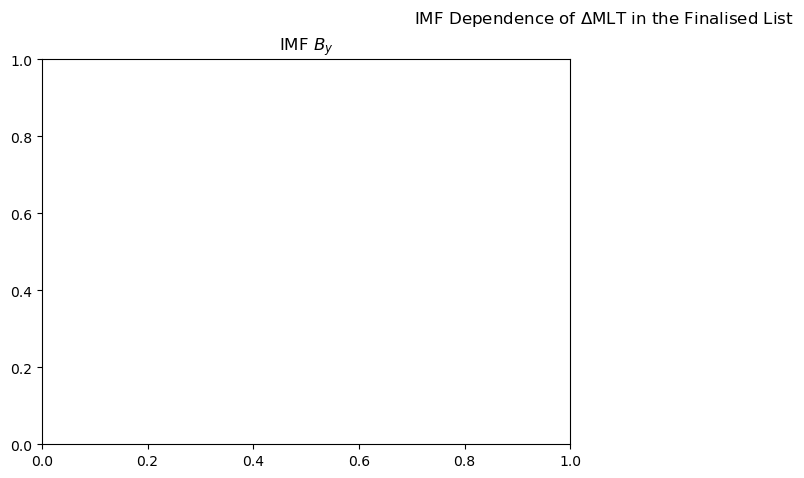

In [138]:
ax= fig.add_subplot(121)
ax.set_title('IMF $B_y$')
fig

#### Scatter Data points

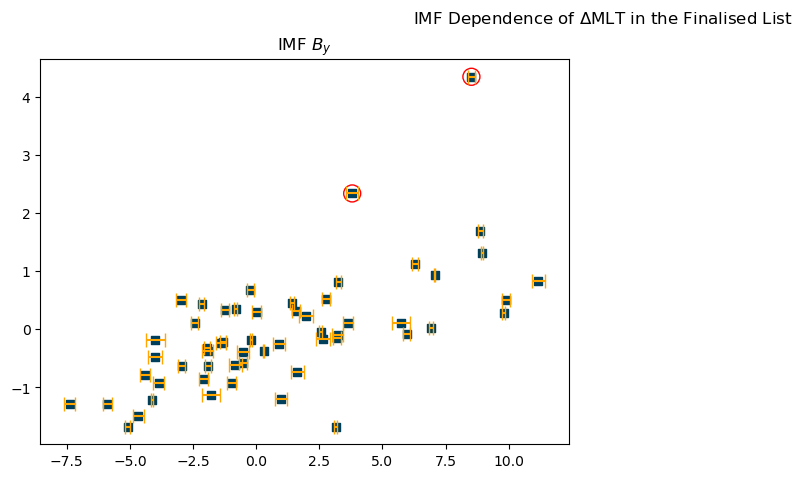

In [139]:
ax.scatter(Onsets[~rm_out].BY_GSM_Mean, Onsets[~rm_out].DMLT, marker= 'o', facecolors='none', edgecolors='r', label='Outliers', s=s*15, zorder=100)
ax.scatter(Onsets.BY_GSM_Mean, Onsets.DMLT, label='Onsets', marker='s', color=colors[0], s=s*3, zorder=101)

ax.errorbar(Onsets.BY_GSM_Mean, Onsets.DMLT, 
            xerr=Onsets.BY_GSM_SEM, label='Standard Error of the Mean', 
            marker='s', ms=0, capsize=5, linestyle='', zorder=102, color=colors[2])
fig

#### Plotting Linear fit

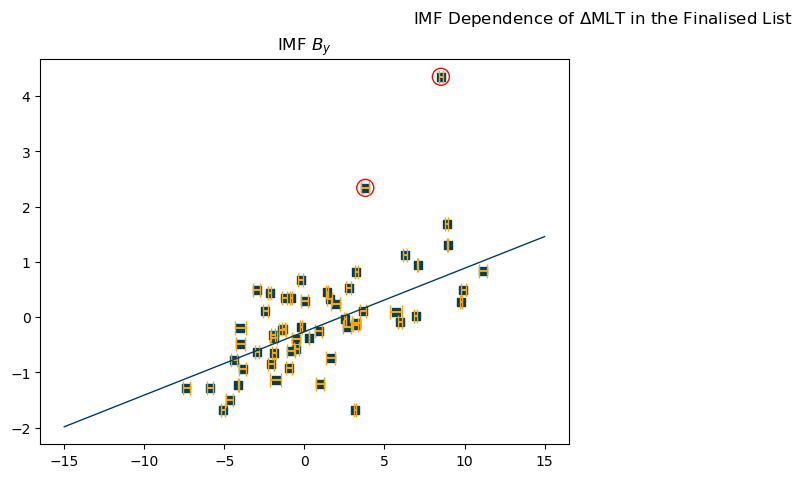

In [140]:
L= L_mean
ts= ts_lin
txt= f'{np.round(L.slope, 3)}'+r'$B_y$'+ f'{np.round(L.intercept, 3):+}\n'+\
      ' '*12+r'$\pm$'+f'{np.round(ts*L.stderr, 3)}'+\
      ' '*3+r'$\pm$'+f'{np.round(ts*L.intercept_stderr, 3)}'
ax.plot(np.linspace(*xlim, 100), L.slope*np.linspace(*xlim, 100) +L.intercept, 
        linestyle='-', lw=1, label=r'$\Delta$MLT='+' '+ txt, color= colors[0], zorder=1000)
fig

#### Confidence Interval for By
We now calculate and plot the 90% confidence interval for the linear fit to By

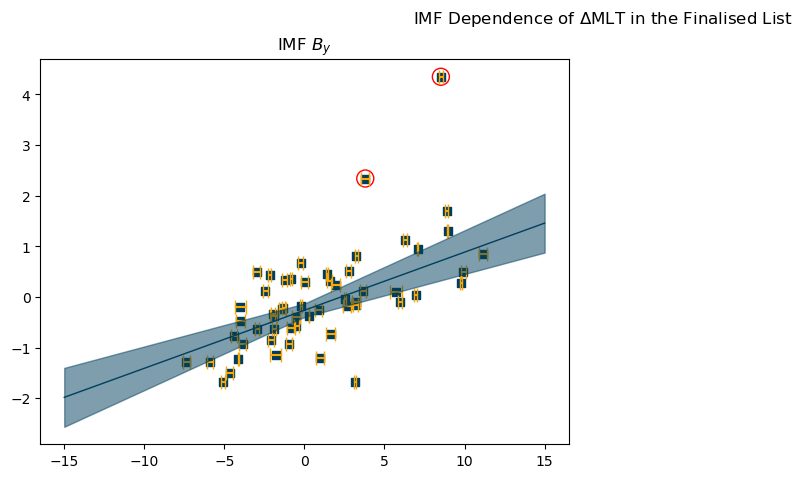

In [141]:
y1= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y2= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)

y3= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)
y4= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y= np.vstack([y1, y2, y3, y4])
ax.fill_between(np.linspace(*xlim, 100), np.min(y, axis=0), np.max(y, axis=0), color=colors[0], alpha=.5, zorder=110, label='90% Confidence\nInterval')
fig

#### Add zero lines and set x and y limits

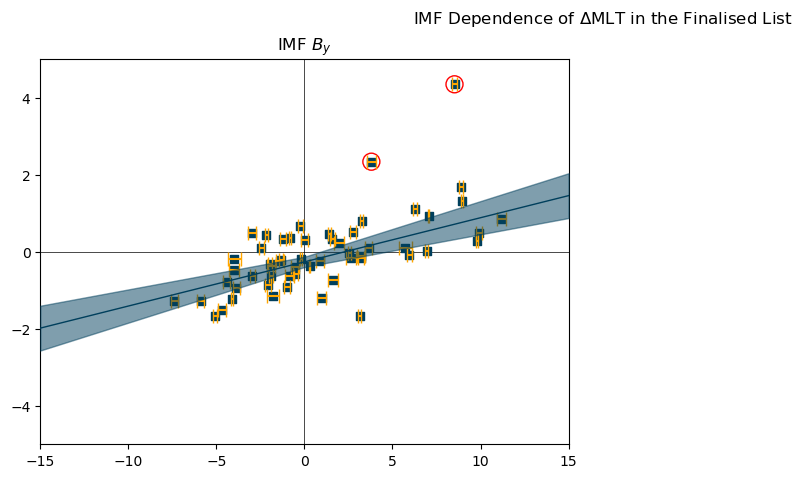

In [142]:
ax.axhline(0, color='black', lw=.5, zorder=-1)
ax.axvline(0, color='black', lw=.5, zorder=-1)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
fig

### Creating Clock Angle Subplot

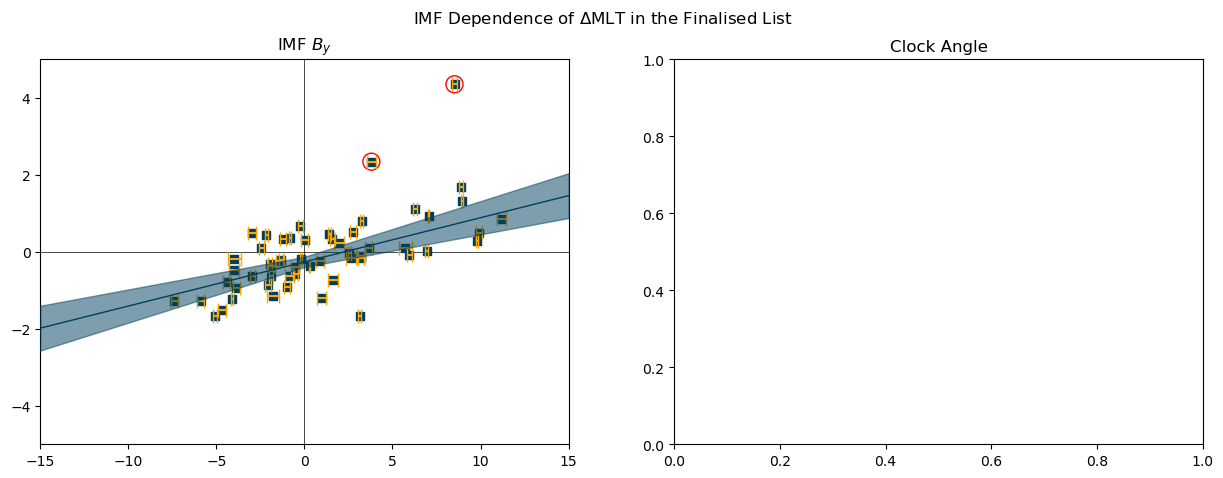

In [143]:
xlim= (0, 360)
ylim= (-5, 5)
ax2= fig.add_subplot(122)
ax2.set_title('Clock Angle')
fig

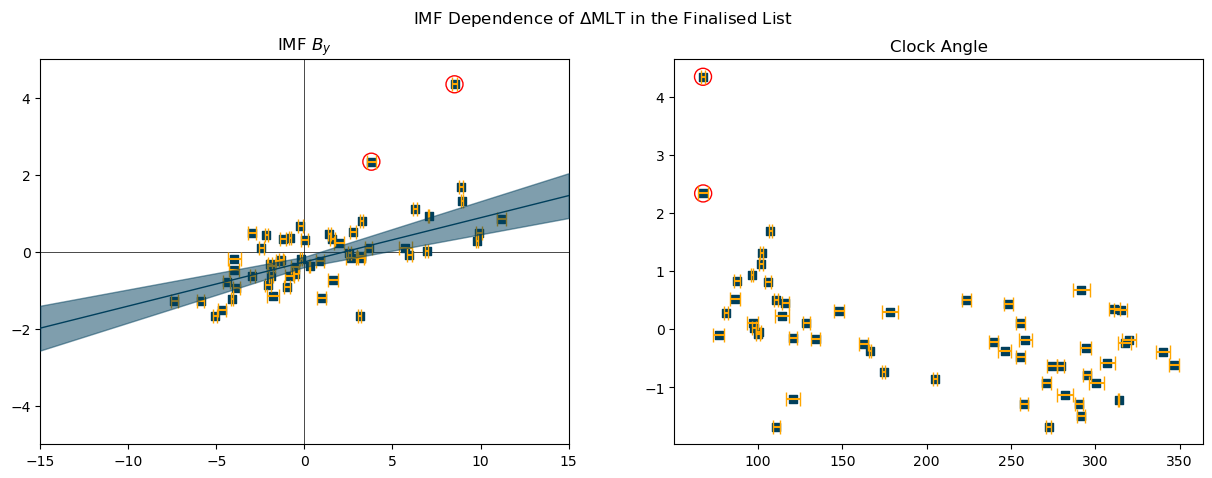

In [144]:
ax2.scatter(Onsets[~rm_out].Clock_GSM_Mean, Onsets[~rm_out].DMLT, marker= 'o', facecolors='none', edgecolors='r', 
            label='Outliers', s=s*15, zorder=0)

ax2.scatter(Onsets.Clock_GSM_Mean, Onsets.DMLT, label=r'Onsets', marker='s', color=colors[0], s=s*4,
            zorder=1)
ax2.errorbar(Onsets.Clock_GSM_Mean, Onsets.DMLT,
            xerr=Onsets.Clock_GSM_SEM, 
            marker='s', ms=0, capsize=5, linestyle='', label='Standard Error of the Mean', zorder=2, color=colors[2])
fig

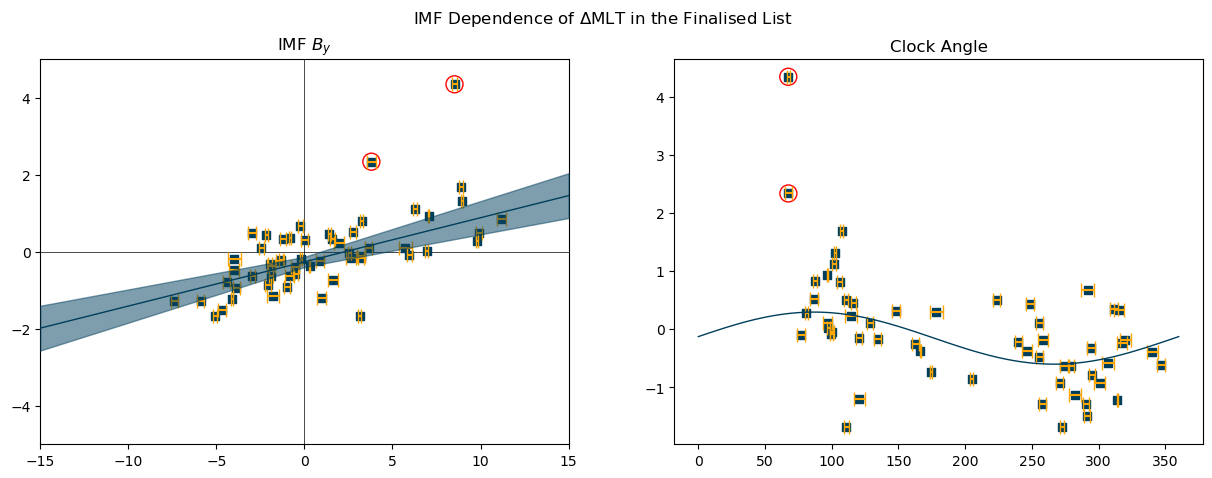

In [145]:
params= params_mean
txt= r'$\Delta$MLT=' f'{np.round(params[0], 3):}sin('+r'$\theta_c$'+\
    f'{np.round(params[1], 3):+})'+f'{np.round(params[-1], 3):+}\n'+\
    ' '*12+r'$\pm$'+f'{np.round(ts * std_errs_mean[0], 3)}'+\
      ' '*5+r'$\pm$'+ f'{np.round(ts * std_errs_mean[1], 3)}'+\
      ' '*2 +r'$\pm$'+ f'{np.round(ts * std_errs_mean[2], 3)}'
ax2.plot(np.linspace(*xlim, 100), func(np.linspace(*xlim, 100), *params), 
         linestyle='-', lw=1, label=r' '+' \n'+ txt, color= colors[0], zorder=1000)

fig

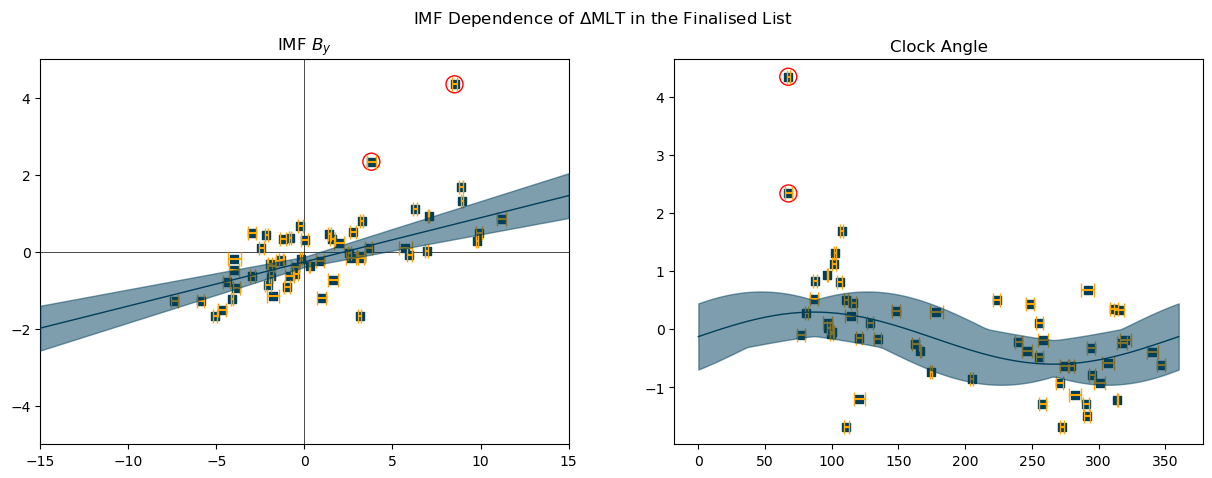

In [146]:
confidence= [ts * std_errs_mean * np.array(combo) for combo in list(itertools.product([1, -1], repeat=3))]
y= np.array([func(np.linspace(*xlim, 100), *(params+conf)) for conf in confidence])


ax2.fill_between(np.linspace(*xlim, 100), np.min(y, axis=0), np.max(y, axis=0), color=colors[0], alpha=.5, 
                 label='90% Confidence\nInterval', zorder=200)
fig

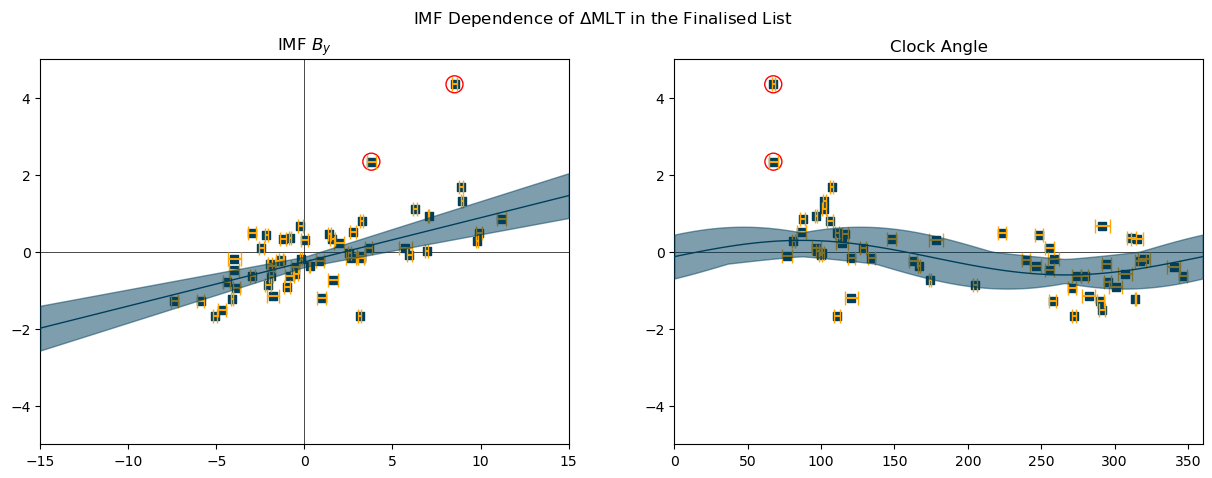

In [147]:
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim)
ax2.axhline(0, color='black', lw=.5, zorder=-1)
fig

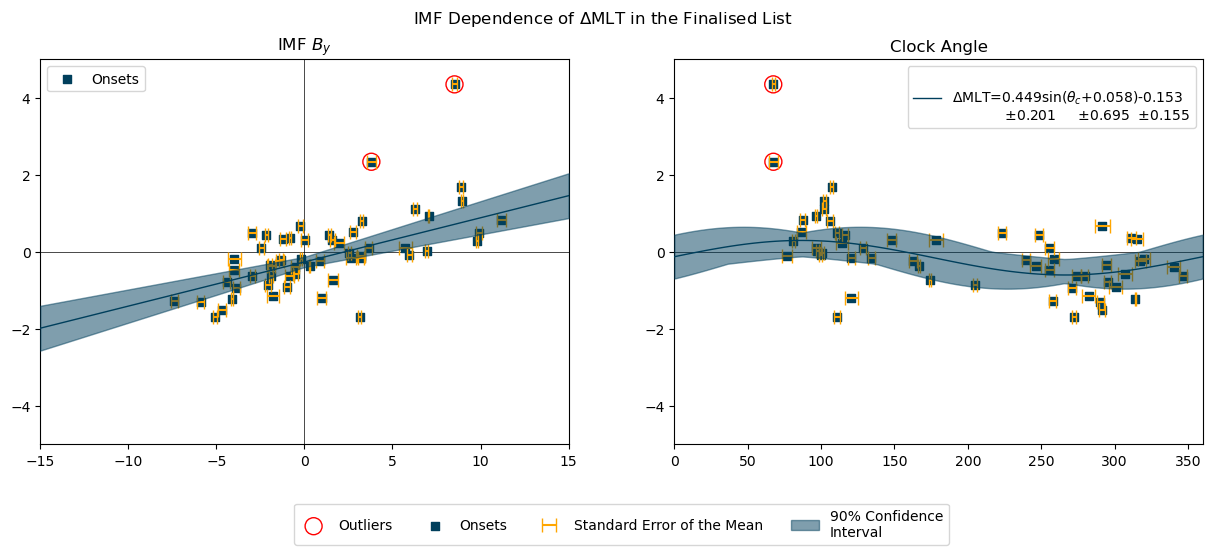

In [148]:
for ax_, loc in zip((ax, ax2), ('upper left', 'upper right')):
    h, l= ax_.get_legend_handles_labels()
    leg=ax_.legend(loc=loc, handles=[h[-1]], labels=[l[-1]])
    leg.set_zorder(10000)
leg1_ax= fig.add_subplot([.1, 0, .4, .1])
subplot_align(leg1_ax, ax, ax2, dim='x')
leg1_ax.axis('off')
h=h[:-3]+[h[-1], h[-2]]
l=l[:-3]+[l[-1], l[-2]]
leg1_ax.legend(loc='center', bbox_to_anchor=(.5, -.5), handles= h, labels= l, ncol=4)
fig

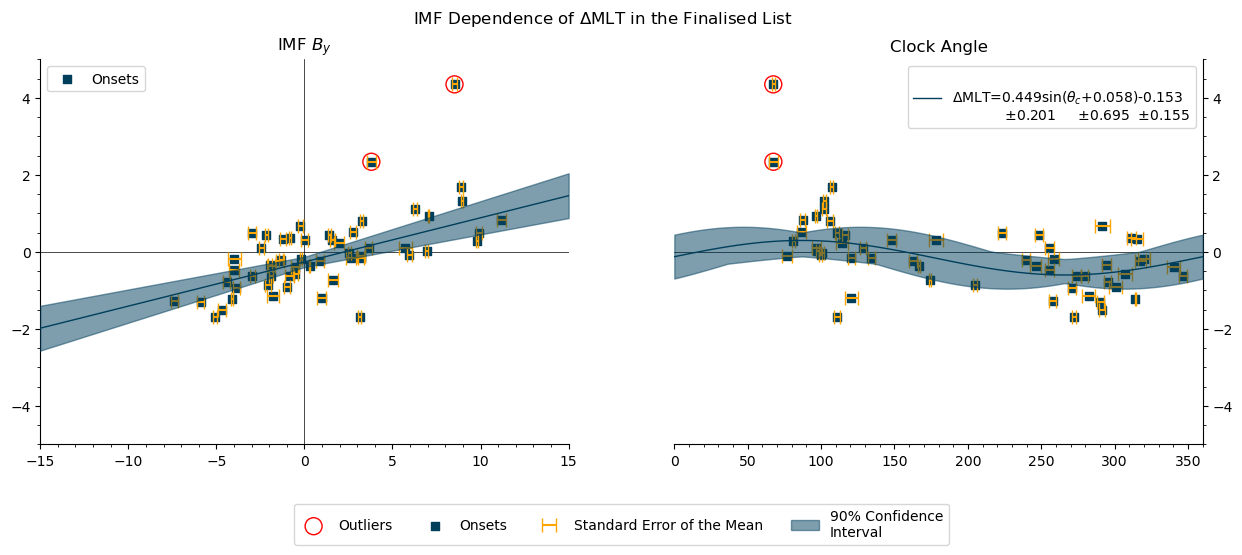

In [149]:
for ax_ in (ax, ax2):
    ax_.spines['top'].set_visible(False)
    ax_.minorticks_on()
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('right')
fig

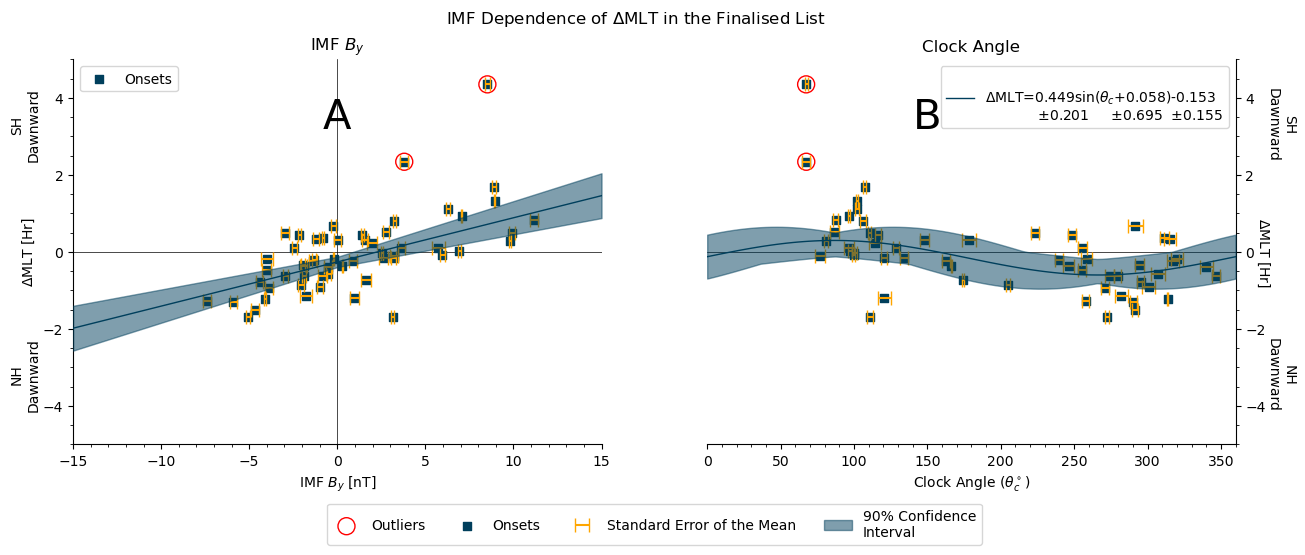

In [150]:
ax.set_ylabel(r'$\Delta$MLT [Hr]', rotation=90)
ax2.set_ylabel(r'$\Delta$MLT [Hr]', rotation=-90)
fig.text(.93, .25, 'NH\nDawnward', rotation=-90, va='center', ha='center')
fig.text(.093, .25, 'NH\nDawnward', rotation=90, va='center', ha='center')

fig.text(.93, .75, 'SH\nDawnward', rotation=-90, va='center', ha='center')
fig.text(.093, .75, 'SH\nDawnward', rotation=90, va='center', ha='center')

ax.set_xlabel(r'IMF $B_y$ [nT]')
ax2.set_xlabel(r'Clock Angle ($\theta_c^\circ$)')

ax.text(0, 3.5, 'A', va='center', ha='center', size=30, zorder=20000)
ax2.text(150, 3.5, 'B', va='center', ha='center', size=30, zorder=20000)
fig

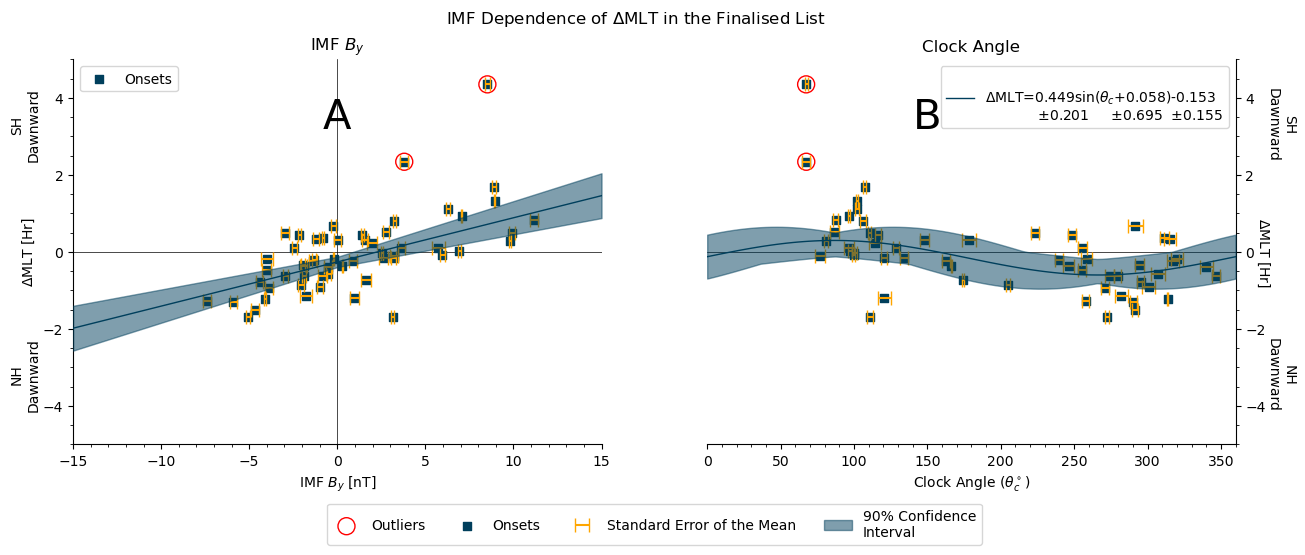

In [151]:
ax.sharey(ax2)
ax2.set_ylim(*ylim)
fig

In [152]:
ax.get_legend_handles_labels()

([<matplotlib.collections.PathCollection at 0x7e7ed33c7220>,
  <ErrorbarContainer object of 3 artists>],
 ['Outliers',
  'Onsets',
  '$\\Delta$MLT= 0.115$B_y$-0.262\n            $\\pm$0.03   $\\pm$0.132',
  'Standard Error of the Mean'])

In [153]:
ax2.get_legend_handles_labels()

([<matplotlib.collections.PathCollection at 0x7e7ed336b490>,
  <ErrorbarContainer object of 3 artists>],
 ['Outliers',
  'Onsets',
  '  \n$\\Delta$MLT=0.449sin($\\theta_c$+0.058)-0.153\n            $\\pm$0.201     $\\pm$0.695  $\\pm$0.155',
  '90% Confidence\nInterval',
  'Standard Error of the Mean'])